In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

input_file = "ds_salaries.csv"
data = pd.read_csv(input_file, header = 0)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [4]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


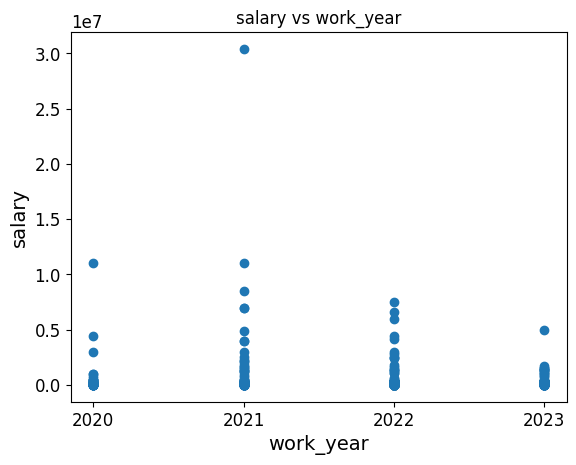

In [3]:
import matplotlib.pyplot as plt

# Create a scatter plot of YearsExperience vs Salary
plt.scatter(data['work_year'], data['salary'])

# Add labels and title to the plot
plt.xticks(range(int(min(data['work_year'])), int(max(data['work_year']))+1, 1))

plt.xlabel('work_year')
plt.ylabel('salary')
plt.title('salary vs work_year')

# Show the plot
plt.show()

Saving figure attribute_histogram_plots


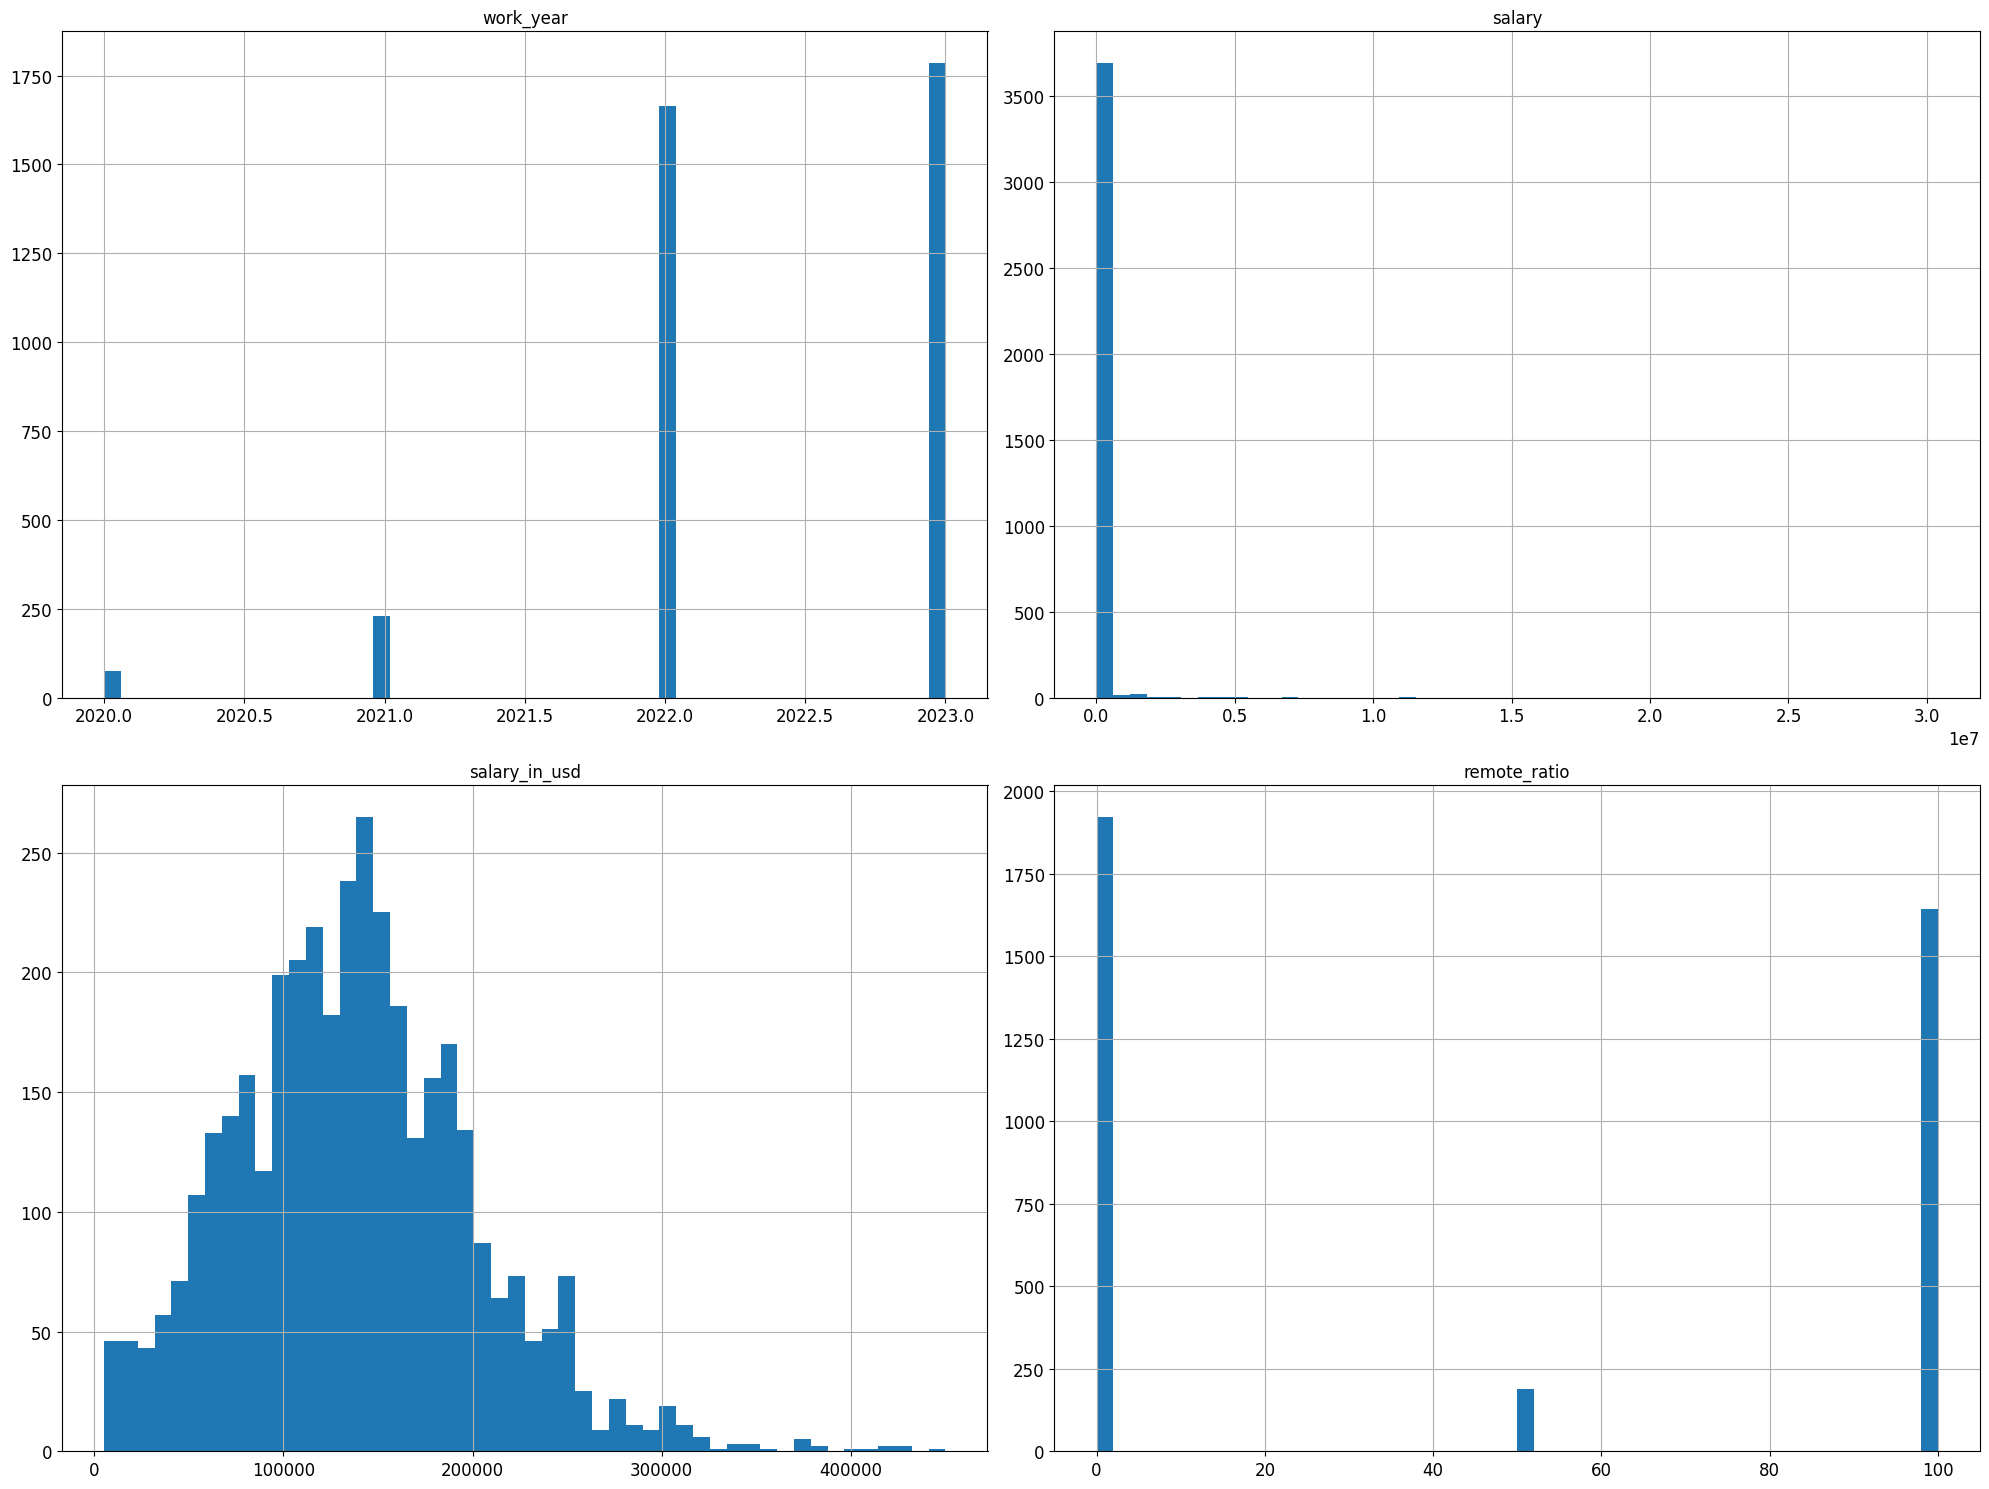

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))

plt.show()

# Clean up the set


#### Check if there are any missing values in our columns

In [5]:
#check for missing values

columns_with_miss = data.isna().sum()
#filtering only the columns with at least 1 missing value
columns_with_miss = columns_with_miss[columns_with_miss!=0]
#The number of columns with missing values
print('Columns with missing values:', len(columns_with_miss))
#sorting the columns by the number of missing values descending
columns_with_miss.sort_values(ascending=False)

Columns with missing values: 0


Series([], dtype: int64)

#### Drop the unuseful columns: salary, salary_currency (both covered by salary_in_usd).

In [6]:
data.drop(columns=['salary', 'salary_currency'], inplace=True)
data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,US,100,US,L


### Transform String data to Integer values
#### First, print all column's possible values to see what we are working with

In [7]:
for column in data.columns:
    if data[column].dtype != 'int64':
        print(data[column].value_counts())
print(data['company_location'].value_counts())

SE    2516
MI     805
EN     320
EX     114
Name: experience_level, dtype: int64
FT    3718
PT      17
CT      10
FL      10
Name: employment_type, dtype: int64
Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: job_title, Length: 93, dtype: int64
US    3004
GB     167
CA      85
ES      80
IN      71
      ... 
BA       1
AM       1
CY       1
KW       1
MT       1
Name: employee_residence, Length: 78, dtype: int64
US    3040
GB     172
CA      87
ES      77
IN      58
      ... 
MK       1
BS       1
IR       1
CR       1
MT       1
Name: company_locati

#### Codify simple, ordinal data
experience_level (entry, mid, senior, executive)

In [8]:
data['experience_level'].replace({
    'EN': 1,
    'MI': 2,
    'SE': 3,
    'EX': 4,
}, inplace=True)

company_size (S, M, L)

In [9]:
data['company_size'].replace({
    'S': 1,
    'M': 2,
    'L': 3
}, inplace=True)

remote_ratio (0, 50, 100) ->  (0, 1, 2)

In [10]:
data['remote_ratio'].replace({
    0: 0,
    50: 1,
    100: 2
}, inplace=True)

#### Codify non-ordinal data
by converting a column to multiple binary value columns

employment_type
FT    2973
PT      15
CT       9
FL       7

In [11]:
# employment_types = pd.get_dummies(data['employment_type'], prefix='employment_type')
# mie imi zice ca le-a convertit deja in coloane diferite, dar in caz ca nu a facut-o, 
#   decomenteaza linia de mai sus si poate da append la data si sterge employment type 
#    din data daca nu se fac singure

job_title simplification (reduce it to 4 main job categories)

In [24]:
def map_job_title_to_category(job_title):
    if "analyst" in job_title.lower():
        return "Data Analyst"
    elif "machine" in job_title.lower():
        return "Machine Learning Engineer"
    elif "scientist" in job_title.lower():
        return "Data Scientist"
    elif "engineer" in job_title.lower():
        return "Data Engineer"
    else:
        return "Other"

# Create a new column called "job_category" and remove old column
data["job_category"] = data["job_title"].apply(map_job_title_to_category)
data["job_category"].value_counts()
data = data.drop('job_title', axis=1)

# Test set

In [7]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# stratify by experience level since that is one of the most important attributes
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["experience_level"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [10]:
#check distribution of train and test
strat_test_set["experience_level"].value_counts() / len(strat_test_set)

SE    0.669774
MI    0.214381
EN    0.085220
EX    0.030626
Name: experience_level, dtype: float64

In [11]:
strat_train_set["experience_level"].value_counts() / len(strat_train_set)

SE    0.670107
MI    0.214381
EN    0.085220
EX    0.030293
Name: experience_level, dtype: float64

#### Check distribution of Experience_level in different sets: Overall, Stratified, Randomized

In [12]:
def income_cat_proportions(data):
    return data["experience_level"].value_counts() / len(data)

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(data),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [13]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
EN,0.085220,0.085220,0.089214,4.687500,0.000000
EX,0.030360,0.030626,0.030626,0.877193,0.877193
MI,0.214381,0.214381,0.209055,-2.484472,0.000000
SE,0.670040,0.669774,0.671105,0.158983,-0.039746


In [15]:
#cautam corelatia dintre salariu si restul atributelor
data = strat_train_set.copy()
corr_matrix = data.corr()
corr_matrix["salary_in_usd"].sort_values(ascending=False)

C:\Users\rober\AppData\Local\Temp\ipykernel_20764\1998377962.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


salary_in_usd    1.000000
work_year        0.230285
remote_ratio    -0.057450
Name: salary_in_usd, dtype: float64